# Modeling

## Import data

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/full_data_final.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (139802, 19)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,Oak,Elm,Pecan,Crape Myrtle,Ashe Juniper,other,total_diameter,canopy_coverage_percentage,PRCP
0,2024-10-24T18:00:00Z,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
1,2024-10-24T06:00:00Z,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
2,2024-10-24T00:00:00Z,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
3,2024-10-23T00:00:00Z,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0
4,2024-10-23T18:00:00Z,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,1192,426,2,49,10,130,22595.5,66.596351,0.0


## Make season variable

In [3]:
# Ensure 'time_stamp' column is datetime type
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# Define a function to assign seasons based on specific start dates
def get_accurate_season(date):
    if pd.isna(date):
        return np.nan  # Return NaN if date is missing (NaT)
    
    month = date.month
    day = date.day
    
    if (month == 12 and day >= 21) or month in [1, 2] or (month == 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or month in [4, 5] or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or month in [7, 8] or (month == 9 and day < 22):
        return 'Summer'
    else:
        return 'Fall'

# Apply the function to create a new 'season' column
df['season'] = df['time_stamp'].apply(get_accurate_season)

# Display the first few rows
df[['time_stamp', 'season']].head()

,time_stamp,season
0,2024-10-24 18:00:00+00:00,Fall
1,2024-10-24 06:00:00+00:00,Fall
2,2024-10-24 00:00:00+00:00,Fall
3,2024-10-23 00:00:00+00:00,Fall
4,2024-10-23 18:00:00+00:00,Fall


### Encode Season Variable

In [4]:
before_drop = df.shape[0]
df = df.dropna(subset=['season'])
after_drop = df.shape[0]
print(f'Loset {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

# One-hot encode the 'season' column
df = pd.get_dummies(df, columns=['season'], prefix='season')

# Display the first few rows
df.head()

Loset 0.07% of data by removing NA


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,Crape Myrtle,Ashe Juniper,other,total_diameter,canopy_coverage_percentage,PRCP,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,49,10,130,22595.5,66.596351,0.0,True,False,False,False


## Random Forest

In [5]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [6]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage', 'PRCP']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lose {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lose 3.81% of data by removing NA


In [8]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [55]:

param_grid = {
    'max_depth': [15, 16, 17, 18]
}

grid = GridSearchCV(RandomForestRegressor(min_samples_split=3, min_samples_leaf=3, n_estimators=190),
                    param_grid=param_grid, n_jobs=-1, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Print best parameters and score from grid search
print("Best parameters:", grid.best_params_)
print("Best mse:", -grid.best_score_)

# Get the best estimator
rf = grid.best_estimator_

Best parameters: {'max_depth': 18}
Best score: 23.469028992220643


In [56]:
from sklearn.metrics import mean_squared_error

'''
Best parameters: {'max_depth': 15, 'n_estimators': 190}
Best score: 23.714400628546002 | 24.899365600825952

Best parameters: {'max_depth': 18}
Best score: 23.469028992220643  24.655659934008835 # Worse

# 175 better than 150 and 225. Also 250 is bad, 150 is bad. Maybe try 175 vs 225

SURE: min_samples_split should be 3, min_samples_leaf should be 3, n_estimators = 190, max_depth >= 7
'''

y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'MSE: {mse}')

MSE: 24.655659934008835


In [9]:

rf_regressor = RandomForestRegressor(
    n_estimators=190,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=3,      # Minimum samples required to split a node
    min_samples_leaf=3,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

# Step 2: Fit the model
rf_regressor.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf_regressor.predict(X_val)


# Step 4: Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 24.9072556962505
R^2 Score: 0.45767573347495194


# Interpretability

In [10]:
import matplotlib.pyplot as plt

plt.ioff()

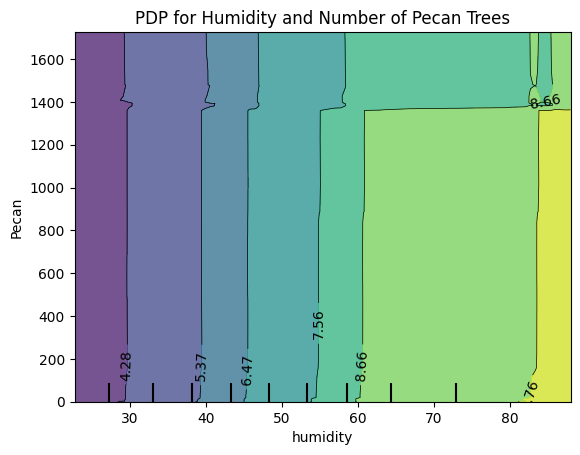

In [13]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# features_PDP = ['humidity']
features_PDP = [('humidity', 'Pecan')]

PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='average')
plt.title('PDP for Humidity and Number of Pecan Trees')
plt.show()

In [32]:
for f in features:
    PartialDependenceDisplay.from_estimator(rf_regressor, X, [f], kind='average')
    name = f.lower().replace(' ', '_')
    title_case = f.replace('_', ' ').replace('PRCP', 'Precipitation').title()
    plt.title(f'PDP for {title_case}')
    plt.xlabel(title_case)
    plt.savefig(f'./plots/pdp_{name}', dpi=300, bbox_inches='tight')
    plt.close()

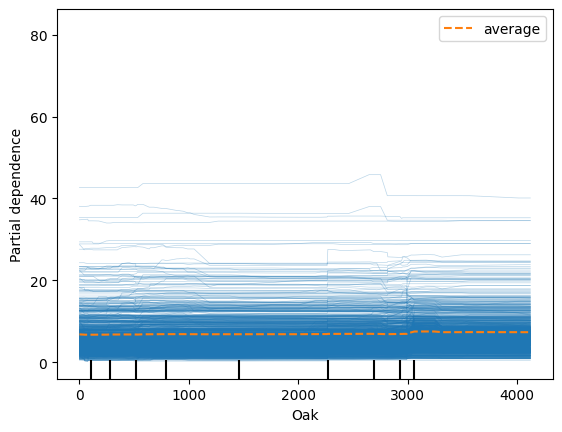

In [13]:
# Takes a long time to run
PartialDependenceDisplay.from_estimator(rf_regressor, X, features_PDP, kind='both')
plt.title('ICE plot')
plt.show()

In [ ]:
from PyALE import ale

ale_eff = ale(X=X, model=rf_regressor, feature=features_PDP, grid_size=50, include_CI=False)
plt.title('ALE plot')
plt.show()

In [21]:
import shap

explainer = shap.TreeExplainer(rf_regressor)
shap_values = explainer(X_train.sample(n=5000, random_state=42))

In [28]:
plt.figure()
shap.plots.waterfall(shap_values[2], show=False)
plt.title('Shapley Value Waterfall Plot')
plt.savefig('./plots/shap_waterfall.png', dpi=300, bbox_inches='tight')

In [29]:
plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.title('Shapley Value Beeswarm Plot')
plt.savefig('./plots/shap_beeswarm.png', dpi=300, bbox_inches='tight')